<a href="https://colab.research.google.com/github/tluxxx/weekly-pattern-in-stock-markets/blob/main/weekly_patterns_(part_2_N_weeks_cycle_with_optimized_pattern).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploiting weekly patterns in stock market for trading
#### part II: based on a strategy-Idea originally generated by Thomas Gebert (Kurzfrist-Strategien fuer Anleger, Boersenbuchverlag, 2019) further modifications are investigated into:

1.   optimizing the pattern of the 16-weeks-cycle using genetic algorithms (GA)
3.   extending the analyses to N-weeks-cycles (N = [4, 52]) and optimizing patterns within each cycle, using GA

In [ ]:
# test for a change

#1. Preparation and Data Upload

In [ ]:
# preparation
from google.colab import drive
drive.mount("/content/gdrive")

!pip install pygad

In [ ]:
# importing all modules
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from tqdm import tqdm
import pygad

In [ ]:
# direct download price dataframe from yfinance
end_date = '2024-03-02' # dt.datetime.now()
start_date = '2000-01-01'
price = yf.download('^GDAXI', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# preparation: resampling daily to weekly data, numbering weeks
price['date'] = price.index
df_input = {'start_w': price.date.resample('W').first(),
             'price': price.Open.resample('W').first()}
price_w = pd.DataFrame(df_input)
price_w = price_w.assign(week_nb=range(len(price_w)))
price_w.set_index('start_w', inplace=True)

In [ ]:
# helper functions

def pnl_calculation(price_w):
  # calculation of PnL ** strategy
  rets = price_w['price'].pct_change()*price_w['pos'].shift(1)
  pnl_strategy = (1 + rets).cumprod()
  pnl_strategy2 = rets.cumsum() + 1
  # calculation of PnL ** buy and hold
  pnl_buyhold = (1 + price_w['price'].pct_change()).cumprod()
  # generation of results dataframe
  input = {'pnl_strategy':pnl_strategy*100, 'pnl_strategy2':pnl_strategy2*100, 'pnl_b&h':pnl_buyhold*100}   # pruefen
  pnl = pd.DataFrame(input)
   # calculating the final results
  strat = pnl['pnl_strategy'][-1]
  strat2 = pnl['pnl_strategy2'][-1]
  buh = pnl['pnl_b&h'][-1]
  return pnl, buh, strat, strat2

def pnl_plotting(pnl, title):
  fig = px.line(pnl, x=pnl.index, y=['pnl_strategy','pnl_strategy2','pnl_b&h'], template='plotly_dark')
  fig.update_layout(title=title)
  fig.update_layout(autosize=False,width=800,height=400)
  fig.update_layout(xaxis_title="Date", yaxis_title='PnL in %')
  fig.show()

# 2. Optimizing the weekly pattern within a 16-weeks cycle


*   trading-times: Mondays at open (9:00)
*   GA via PyGAD-module

In [ ]:
# function to be optimized via GA --> strat --> max

def opt_pattern1(ga_instance,pos,pos_idx):
  pos_dict = dict(enumerate(pos))
  cycle = len(pos)
  # calculation of week-type and resulting positions depending on the shift
  price_w['week_type'] = (price_w['week_nb']) % cycle
  price_w['pos'] = price_w['week_type'].map(pos_dict)
  pnl, buh, strat, strat2  = pnl_calculation(price_w)
  return strat

In [ ]:
cycle = 16

In [ ]:
ga_instance = pygad.GA(num_generations=60,
                       num_parents_mating=4,
                       fitness_func=opt_pattern1,
                       sol_per_pop=8,
                       num_genes=cycle,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)

In [ ]:
ga_instance.run()

In [ ]:
pos, strat, strat_idx = ga_instance.best_solution()
print(pos)
print(strat)

[ 1  1  1 -1  1  1  1  1  0  0  1 -1  0 -1 -1 -1]
11240.864344968983


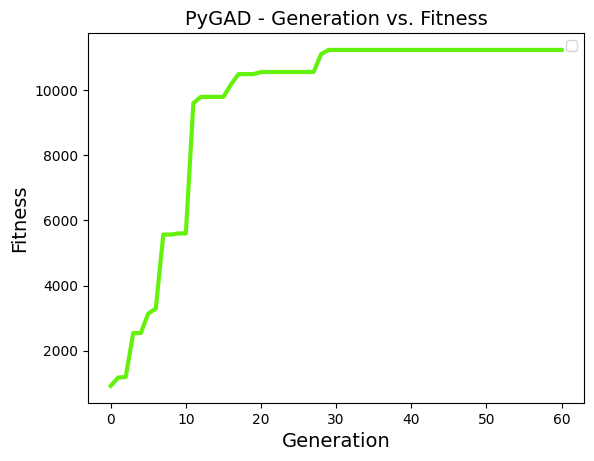

In [ ]:
fig = ga_instance.plot_fitness()

#3. Optimizing the weekly pattern within different N-week-cycles

*   brute-force looping through all cycles between 4w (= one month) and 52 weeks (= one year)
*   tradings times (first trading day of the week at 9:00 (=open)
*   GA via PyGAD



In [ ]:
# preparation of dataframe for storing results
results = pd.DataFrame(columns=['cycle', 'strat', 'pattern'])
# looping through various cycles
for cycle in tqdm(range(4,52)):
  ga_instance = pygad.GA(num_generations=100,
                       num_parents_mating=4,
                       fitness_func=opt_pattern1,
                       sol_per_pop=8,
                       num_genes=cycle,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)
  ga_instance.run()
  pos, strat, strat_idx = ga_instance.best_solution()
  print(f' cycles:  {cycle}     Strategy:    {strat:.2f} %'   )
  results.loc[len(results.index)] = [cycle, strat, pos]

  2%|▏         | 1/48 [00:02<02:11,  2.80s/it]

 cycles:  4     Strategy:    1016.7796575148985


  4%|▍         | 2/48 [00:05<02:05,  2.73s/it]

 cycles:  5     Strategy:    249.89140180155184


  6%|▋         | 3/48 [00:07<01:53,  2.53s/it]

 cycles:  6     Strategy:    502.11597132147335


  8%|▊         | 4/48 [00:10<01:49,  2.48s/it]

 cycles:  7     Strategy:    406.4035965638527


 10%|█         | 5/48 [00:12<01:45,  2.46s/it]

 cycles:  8     Strategy:    4175.908967160806


 12%|█▎        | 6/48 [00:15<01:47,  2.55s/it]

 cycles:  9     Strategy:    649.7190458155467


 15%|█▍        | 7/48 [00:18<01:52,  2.75s/it]

 cycles:  10     Strategy:    475.5245697028663


 17%|█▋        | 8/48 [00:20<01:45,  2.64s/it]

 cycles:  11     Strategy:    2712.104597553402


 19%|█▉        | 9/48 [00:23<01:40,  2.59s/it]

 cycles:  12     Strategy:    1217.2535595634324


 21%|██        | 10/48 [00:25<01:37,  2.56s/it]

 cycles:  13     Strategy:    1327.2456399145062


 23%|██▎       | 11/48 [00:28<01:36,  2.61s/it]

 cycles:  14     Strategy:    1150.132801902097


 25%|██▌       | 12/48 [00:31<01:41,  2.83s/it]

 cycles:  15     Strategy:    424.5876138694942


 27%|██▋       | 13/48 [00:34<01:35,  2.73s/it]

 cycles:  16     Strategy:    13585.388089333534


 29%|██▉       | 14/48 [00:36<01:30,  2.66s/it]

 cycles:  17     Strategy:    2404.459368244258


 31%|███▏      | 15/48 [00:39<01:25,  2.60s/it]

 cycles:  18     Strategy:    1772.3547473953272


 33%|███▎      | 16/48 [00:42<01:23,  2.62s/it]

 cycles:  19     Strategy:    1135.5580835008923


 35%|███▌      | 17/48 [00:45<01:29,  2.87s/it]

 cycles:  20     Strategy:    1716.1986998440573


 38%|███▊      | 18/48 [00:48<01:23,  2.78s/it]

 cycles:  21     Strategy:    3878.7202448879307


 40%|███▉      | 19/48 [00:50<01:19,  2.73s/it]

 cycles:  22     Strategy:    5146.339419074362


 42%|████▏     | 20/48 [00:53<01:15,  2.70s/it]

 cycles:  23     Strategy:    2633.9420727250385


 44%|████▍     | 21/48 [00:56<01:14,  2.77s/it]

 cycles:  24     Strategy:    10277.796039788438


 46%|████▌     | 22/48 [00:59<01:16,  2.94s/it]

 cycles:  25     Strategy:    4229.867557674809


 48%|████▊     | 23/48 [01:02<01:11,  2.84s/it]

 cycles:  26     Strategy:    3888.3579674994153


 50%|█████     | 24/48 [01:04<01:06,  2.77s/it]

 cycles:  27     Strategy:    3057.2862630166787


 52%|█████▏    | 25/48 [01:07<01:02,  2.73s/it]

 cycles:  28     Strategy:    5777.804843698486


 54%|█████▍    | 26/48 [01:11<01:07,  3.06s/it]

 cycles:  29     Strategy:    5716.707614572269


 56%|█████▋    | 27/48 [01:14<01:07,  3.23s/it]

 cycles:  30     Strategy:    1396.4410811103544


 58%|█████▊    | 28/48 [01:17<01:01,  3.05s/it]

 cycles:  31     Strategy:    4137.884737055442


 60%|██████    | 29/48 [01:20<00:55,  2.93s/it]

 cycles:  32     Strategy:    40684.974142480925


 62%|██████▎   | 30/48 [01:22<00:51,  2.84s/it]

 cycles:  33     Strategy:    30406.011532342323


 65%|██████▍   | 31/48 [01:26<00:52,  3.06s/it]

 cycles:  34     Strategy:    5646.35937826287


 67%|██████▋   | 32/48 [01:29<00:49,  3.10s/it]

 cycles:  35     Strategy:    4918.461515761505


 69%|██████▉   | 33/48 [01:32<00:44,  2.96s/it]

 cycles:  36     Strategy:    4844.773380977265


 71%|███████   | 34/48 [01:34<00:40,  2.86s/it]

 cycles:  37     Strategy:    8864.49634332584


 73%|███████▎  | 35/48 [01:37<00:37,  2.88s/it]

 cycles:  38     Strategy:    4424.258698684399


 75%|███████▌  | 36/48 [01:41<00:36,  3.02s/it]

 cycles:  39     Strategy:    11874.396667648856


 77%|███████▋  | 37/48 [01:43<00:32,  2.92s/it]

 cycles:  40     Strategy:    12329.161404757633


 79%|███████▉  | 38/48 [01:46<00:28,  2.83s/it]

 cycles:  41     Strategy:    11032.594278947785


 81%|████████▏ | 39/48 [01:49<00:24,  2.77s/it]

 cycles:  42     Strategy:    7551.413107007113


 83%|████████▎ | 40/48 [01:52<00:23,  2.92s/it]

 cycles:  43     Strategy:    12077.801409247804


 85%|████████▌ | 41/48 [01:56<00:22,  3.27s/it]

 cycles:  44     Strategy:    11161.312032046164


 88%|████████▊ | 42/48 [01:59<00:18,  3.08s/it]

 cycles:  45     Strategy:    9922.059578680983


 90%|████████▉ | 43/48 [02:01<00:14,  2.96s/it]

 cycles:  46     Strategy:    8259.936313765156


 92%|█████████▏| 44/48 [02:04<00:11,  2.94s/it]

 cycles:  47     Strategy:    8113.721303269402


 94%|█████████▍| 45/48 [02:08<00:09,  3.10s/it]

 cycles:  48     Strategy:    54289.45186892072


 96%|█████████▌| 46/48 [02:10<00:05,  2.96s/it]

 cycles:  49     Strategy:    13587.270962251941


 98%|█████████▊| 47/48 [02:13<00:02,  2.87s/it]

 cycles:  50     Strategy:    5412.50983556217


100%|██████████| 48/48 [02:16<00:00,  2.83s/it]

 cycles:  51     Strategy:    3948.088043675306


In [ ]:
fig = px.bar(results, x=results['cycle'], y=results['strat'])
fig.update_layout(title='optimized returns for various cycles')
fig.update_layout(autosize=False,width=1400,height=400)
fig.update_layout(xaxis_title="cycle length [wks]", yaxis_title='PnL in %')

In [ ]:
# display of results as table
pd.options.display.float_format = '{:,.2f} %'.format
results.sort_values(by=['strat'], ascending=False)

,cycle,strat,pattern
44,48,"54,289.45 %","[1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 0,..."
28,32,"40,684.97 %","[1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 0, 0,..."
29,33,"30,406.01 %","[-1, 1, 1, 1, 1, 1, -1, 0, 1, -1, -1, -1, 0, 1..."
45,49,"13,587.27 %","[-1, 0, 1, -1, 1, -1, -1, -1, 0, 1, 0, 1, 0, 0..."
12,16,"13,585.39 %","[1, 1, 1, -1, 1, 1, 1, 1, 1, 0, 1, -1, 1, -1, ..."
36,40,"12,329.16 %","[-1, 0, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 0, 0,..."
39,43,"12,077.80 %","[1, 0, -1, -1, -1, 1, 1, 1, 1, -1, 0, 1, 1, -1..."
35,39,"11,874.40 %","[-1, 1, 1, -1, 1, -1, 1, -1, 0, -1, -1, 1, 1, ..."
40,44,"11,161.31 %","[-1, 1, 1, 1, 1, 1, -1, 1, 1, 0, 1, -1, -1, 1,..."
37,41,"11,032.59 %","[-1, 1, 0, 1, -1, 1, 0, 0, -1, 1, 0, 1, 1, 1, ..."
